## dicom을 point cloud 데이터로 만들기 연습

 - URL : https://github.com/christopherpoole/dicom2ply

In [39]:
import os
import sys

import dicom
import numpy
import pylab

from PIL import Image, ImageDraw
   

class Contour(object):
    def __init__(self, contour, dicom_dir='', bins=2**12):
        self.dicom_dir = dicom_dir
        self.bins = bins
        self.slice_ref = contour.ContourImages[0].RefdSOPInstanceUID
                
        self.y = contour.ContourData[0::3]
        self.x = contour.ContourData[1::3]
        self.z = contour.ContourData[2::3]
        
        self.vertex_count = len(self.x)
        
        self._stats()        
        
    def _stats(self):
        self.slice_file = dicom.read_file("%s/CT%s.dcm" % (self.dicom_dir, self.slice_ref))
        self.slice_data = self.slice_file.pixel_array

        self.position = self.slice_file.ImagePositionPatient 
        self.resolution = self.slice_file.PixelSpacing
        self.thickness = self.slice_file.SliceThickness

        x = numpy.array(self.x) + self.slice_file.TableHeight
        y = numpy.array(self.y) + 256
                
        self.mask = self._get_mask(x, y)
        
        self.masked = self.slice_data * self.mask
        self.masked = self.masked.flatten()
        self.masked = self.masked[self.masked.nonzero()[0]]
        
        if self.masked.size == 0:
            self.histogram = None
            self.mode = None
            self.mean = None
            self.std = None
            self.median = None
        else:
            self.histogram = numpy.histogram(self.masked, bins=self.bins)
            self.mode = self.histogram[1][numpy.argmax(self.histogram[0])]
            self.mean = numpy.mean(self.masked)
            self.std = numpy.std(self.masked)
            self.median = numpy.median(self.masked) 
        
    def _get_mask(self, x, y, shape=(512, 512)):
        pylab.plot(x, y)
    
        mask = numpy.zeros(shape)
        points = []
        for i in range(0, len(x)):
            points.append((x[i], y[i]))
        
        if len(points) < 3:
            return mask
        
        im = Image.fromarray(mask)
        draw = ImageDraw.Draw(im)
        draw.polygon(points, fill=1)
        mask = numpy.asarray(im)
        
        return mask.astype(numpy.int8)
        
        
class RegionOfInterest(object):
    def __init__(self, roi, name, dicom_dir='', bins=2**12):
        self.dicom_dir = dicom_dir
        self.bins = bins
                
        self.name = name
                
        self.contours = []
        self.vertex_count = 0
        for contour in roi.Contours:
            c = Contour(contour, dicom_dir=self.dicom_dir)
            if c.mean is None:
                continue
            self.contours.append(c)
            self.vertex_count += c.vertex_count       
        
        self._stats()
  
        end = [numpy.zeros((512, 512)), ]
        stack = [c.mask for c in self.contours]
        self.mask = numpy.dstack(end + stack + end)
        self.mask[0, 0, 0] = 1   
        self.mask[-1, -1, -1] = 1   

        xmin, ymin, zmin = self.contours[0].position
        xmax = xmin + (self.contours[0].resolution[0] * 512)
        ymax = ymin + (self.contours[0].resolution[1] * 512)

        zmin -= self.contours[0].thickness
        zmax = zmin + (self.contours[0].thickness * (self.mask.shape[2] + 2))

        self.extent = (xmin, xmax, ymin, ymax, zmin, zmax)

    def __len__(self):
        return len(self.contours)
    
    
    def _stats(self):
        masked = numpy.empty((0))
        
        for c in self.contours:
            masked = numpy.append(masked, c.masked)
        
        try:
            self.histogram = numpy.histogram(masked.flatten(), bins=self.bins)
            self.mode = self.histogram[1][numpy.argmax(self.histogram[0])]
            self.mean = numpy.mean(masked)
            self.std = numpy.std(masked)
            self.median = numpy.median(masked)
            self.sum = numpy.sum(masked)
            self.len = len(masked)
        except ValueError:
            return
            
    @property
    def mask_sum(self):
        total = 0
        for c in self.contours:
            total += c.mask.sum()
        return total
        
        
    @property
    def masked_sum(self):
        total = 0
        for c in self.contours:
            total += c.masked.sum()
        return total 


class Patient(object):
    def __init__(self, dicom_dir, debug=True):
        self.debug = debug
        self.dicom_dir = dicom_dir
        
        self.files = os.walk(self.dicom_dir).__next__()[2]
            
        '''
        for f in self.files:
            if f[:2] == 'RS':
                dicom_structure = f
                print(f)
                break
        '''
        
        dicom_structure = self.files[int(len(self.files)/2)]
        
        self.structure = dicom.read_file("%s/%s" % (dicom_dir, dicom_structure))
        
        self.region_names = {}
        for i, roi in enumerate(self.structure.RTROIObservations):
            try:
                name = roi.ROIObservationLabel
            except AttributeError:
                name = i
            number = roi.ObservationNumber
            self.region_names[number] = name
        
        self.regions = {}
        for roi in self.structure.ROIContours:
            number = roi.ReferencedROINumber
            try:
                name = self.region_names[number]
            except KeyError:
                # ROI did not have a label
                continue
            
            try:
                roi.Contours
            except AttributeError:
                # Not an ROI with geometry
                continue

            r = RegionOfInterest(roi, name, dicom_dir)
            self.regions[self.region_names[number]] = r

   
    def dump_ply(self, directory='.', names=[]):
        if names == []:
            names = self.regions.keys()
          
        for n in names:
            print(n)
            roi = self.regions[n]
            
            ply_verts = []
            for contour in roi.contours:
                for i in range(contour.vertex_count):
                    ply_verts.append("%f %f %f" % (contour.x[i], contour.y[i], contour.z[i]))
            
            try:
                ply_header = ['ply',
                    'format ascii 1.0',
                    'comment name roi_%s' % roi.name,
                    'comment mean %f' % roi.mean,
                    'comment std %f' % roi.std,
                    'comment median %f' % roi.median,
                    'comment mode %f' % roi.mode,
                    'comment sum %f' % roi.sum,
                    'comment len %f' % roi.len,
                    'element vertex %i' % roi.vertex_count,
                    'property float x',
                    'property float y',
                    'property float z',
                    'end_header']
            except AttributeError:
                print(" - fail")
                continue           
            file_name = "%s/roi_%s.ply" % (directory, roi.name)
            print(file_name)
            ply_file = file(file_name, 'w')
            for line in ply_header:
                ply_file.write("%s\n" % line)
            for line in ply_verts:
                ply_file.write("%s\n" % line)    
            ply_file.close()
    
    @property
    def roi_names(self):
        return self._rois.keys() 

In [40]:
patient = Patient('C:/Users/dDk13/Desktop/ddk_test/PointCloudTest/data/human_data')
patient.dump_ply('01_export_data/')

AttributeError: Dataset does not have attribute 'RTROIObservations'.

In [28]:
debug = True
dicom_dir = 'C:/Users/dDk13/Desktop/ddk_test/PointCloudTest/data/human_data'

files = os.walk(dicom_dir).__next__()[2]

In [30]:
for f in files:
    print(f)
    if f[:2] == 'RS':
        dicom_structure = f
        print(f)
        break

000000.dcm
000001.dcm
000002.dcm
000003.dcm
000004.dcm
000005.dcm
000006.dcm
000007.dcm
000008.dcm
000009.dcm
000010.dcm
000011.dcm
000012.dcm
000013.dcm
000014.dcm
000015.dcm
000016.dcm
000017.dcm
000018.dcm
000019.dcm
000020.dcm
000021.dcm
000022.dcm
000023.dcm
000024.dcm
000025.dcm
000026.dcm
000027.dcm
000028.dcm
000029.dcm
000030.dcm
000031.dcm
000032.dcm
000033.dcm
000034.dcm
000035.dcm
000036.dcm
000037.dcm
000038.dcm
000039.dcm
000040.dcm
000041.dcm
000042.dcm
000043.dcm
000044.dcm
000045.dcm
000046.dcm
000047.dcm
000048.dcm
000049.dcm
000050.dcm
000051.dcm
000052.dcm
000053.dcm
000054.dcm
000055.dcm
000056.dcm
000057.dcm
000058.dcm
000059.dcm
000060.dcm
000061.dcm
000062.dcm
000063.dcm
000064.dcm
000065.dcm
000066.dcm
000067.dcm
000068.dcm
000069.dcm
000070.dcm
000071.dcm
000072.dcm
000073.dcm
000074.dcm
000075.dcm
000076.dcm
000077.dcm
000078.dcm
000079.dcm
000080.dcm
000081.dcm
000082.dcm
000083.dcm
000084.dcm
000085.dcm
000086.dcm
000087.dcm
000088.dcm
000089.dcm
000090.dcm

In [37]:
structure = dicom.read_file("%s/%s" % (dicom_dir, files[int(len(files)/2)]))

In [44]:
structure

(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'AXIAL']
(0008, 0012) Instance Creation Date              DA: '19980803'
(0008, 0013) Instance Creation Time              TM: '121721'
(0008, 0016) SOP Class UID                       UI: CT Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.3.6.1.4.1.14519.5.2.1.3023.4024.507326735282414971239577308860
(0008, 0020) Study Date                          DA: '19980803'
(0008, 0021) Series Date                         DA: '19980803'
(0008, 0022) Acquisition Date                    DA: '19980803'
(0008, 0023) Content Date                        DA: '19980803'
(0008, 0030) Study Time                          TM: '121331.000000'
(0008, 0031) Series Time                         TM: '121634'
(0008, 0032) Acquisition Time                    TM: '121656'
(0008, 0033) Content Time                        TM: '121721'
(0008, 0050) Accession 

Text(0.5, 0.98, 'test CT data')

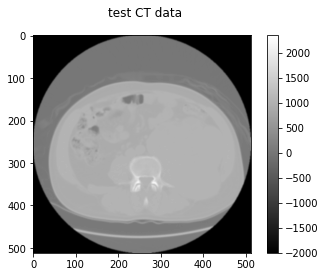

In [43]:
# set jupyter property(?)
%matplotlib inline

# import module
import matplotlib.pyplot as plt

dc_1_pxd = structure.pixel_array

fig1  = plt.figure()
plt.imshow(dc_1_pxd, cmap="gray", interpolation="bicubic")
plt.colorbar()
fig1.suptitle("test CT data", fontsize=12)